In [26]:
from typing import Sequence

import numpy
import pandas
from matplotlib import pyplot
from scipy import stats
from statsmodels.stats.multitest import multipletests

%matplotlib notebook

Описание данных:

* `userID`: уникальный идентификатор пользователя
* `browser`: браузер, который использовал `userID`
* `slot`: в каком статусе пользователь участвовал в исследовании (`exp` = видел измененную страницу, `control` = видел неизменную страницу)
* `n_clicks`: количество кликов, которые пользоваль совершил за `n_queries`
* `n_queries`: количество запросов, который совершил `userID`, пользуясь браузером `browser`
* `n_nonclk_queries`: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце `userID` есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание `userID и browser`.

In [27]:
dataset = pandas.read_csv('ab_browser_test.csv')

In [28]:
dataset.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе `exp` больше пользовательских кликов по сравнению с группой `control` в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [29]:
exp = dataset[dataset['slot'] == 'exp']
control = dataset[dataset['slot'] == 'control']

In [30]:
print(f'{100 * (exp["n_clicks"].sum() / control["n_clicks"].sum() - 1):.3f}')

1.614


Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [31]:
def sample(data: Sequence, n_samples: int):
    return data[numpy.random.randint(0, len(data), (n_samples, len(data)))]

def statistics_intervals(statistics: Sequence, alpha: float):
    return numpy.percentile(statistics, [100 * alpha / 2, 100 * (1 - alpha / 2)])

numpy.random.seed(42)
n_samples = 100
print(statistics_intervals(
    numpy.median(sample(exp['n_clicks'].values, n_samples), axis=1)
    - numpy.median(sample(control['n_clicks'].values, n_samples), axis=1),
    0.05,
))
print(statistics_intervals(
    numpy.mean(sample(exp['n_clicks'].values, n_samples), axis=1)
    - numpy.mean(sample(control['n_clicks'].values, n_samples), axis=1),
    0.05,
))

[1. 1.]
[0.2060922  0.39099905]


* 95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо
* 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

* Все ответы неверны

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

* Получите из данных `n_boot_samples` псевдовыборок.
* По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (`control_boot_chi_squared`)
* Для получившегося вектора средних значений из `n_boot_samples` постройте q-q plot с помощью `scipy.stats.probplot` для нормального распределения
* Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью `scipy.stats.probplot` для хи-квадрат распределения с помощью команды `scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n-1), plot=plt)`, где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

<IPython.core.display.Javascript object>


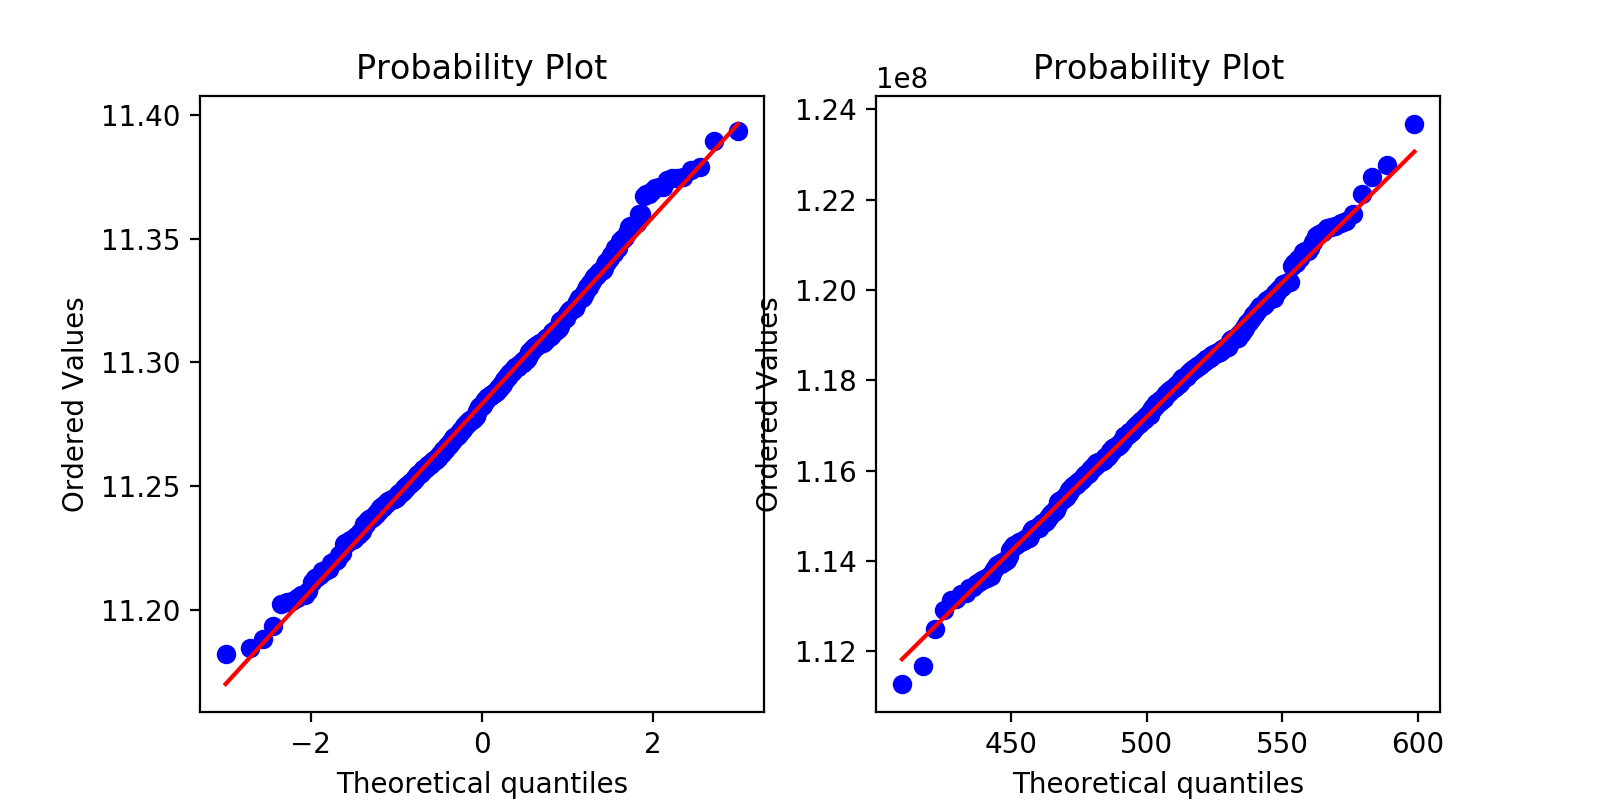

r2 mean: 0.995953774208204
r2 MSE: 0.9972851848247719


In [32]:
numpy.random.seed(0)
n_boot_samples = 500

_, (axis_1, axis_2) = pyplot.subplots(1, 2, figsize=(8, 4))
samples = sample(control['n_clicks'].values, n_boot_samples)

_, (_, _, r_mean) = stats.probplot(samples.mean(axis=1), plot=axis_1)
_, (_, _, r_mse) = stats.probplot(
    ((samples - samples.mean(axis=1).reshape((n_boot_samples, 1))) ** 2).sum(axis=1), 
    dist='chi2',
    sparams=(n_boot_samples - 1), plot=axis_2)
pyplot.show()

print(f'r2 mean: {r_mean ** 2}')
print(f'r2 MSE: {r_mse ** 2}')

В качестве ответа отметьте верные утвердения о значениях R2, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.

* R2 для выборочного среднего получился больше, чем 0.99
* R2 для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [33]:
stats.mannwhitneyu(exp.groupby('userID').sum()['n_clicks'], control.groupby('userID').sum()['n_clicks'])

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

* Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца `browser`) критерий Манна-Уитни между `control` и `exp` группами и сделайте поправку Холма-Бонферрони на множественную проверку с `α=0.05`.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [35]:
comparison = pandas.DataFrame([{
    'browser': browser, 
    'pvalue': stats.mannwhitneyu(
        control[control['browser'] == browser]['n_clicks'], 
        exp[exp['browser'] == browser]['n_clicks'],
    ).pvalue
} for browser in dataset['browser'].value_counts().keys()])
print(comparison)
reject, *_ = multipletests(comparison['pvalue'], method='holm')
reject

       browser    pvalue
0   Browser #4  0.407606
1  Browser #22  0.257406
2   Browser #2  0.027244
3  Browser #14  0.000000
4  Browser #20  0.453667
5  Browser #17  0.037401


array([False, False, False,  True, False, False])

Для каждого браузера в каждой из двух групп (`control` и `exp`) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений `n_nonclk_queries` на сумму значений `n_queries`. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

In [40]:
pandas.concat([
    control.groupby('browser').sum().apply(lambda row: row['n_nonclk_queries'] / row['n_queries'], axis=1),
    exp.groupby('browser').sum().apply(lambda row: row['n_nonclk_queries'] / row['n_queries'], axis=1),
], axis=1)

,0,1
browser,,
Browser #14,0.575904,0.437556
Browser #17,0.362994,0.369374
Browser #2,0.459627,0.449827
Browser #20,0.405405,0.389774
Browser #22,0.405940,0.398539
Browser #4,0.469709,0.451429


* С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.